#**Практическое задание №1**

### Файзуллов Айрат 402 группа

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '13-p56cptVKjfLtLsr9i8cQ_JIcahIcMV',
    'train_small': '1FosyL3b5rnMBaglli3ZNLDC6uNccaat5',
    'train_tiny': '1SxcuL7q7zOteDDlf07rIdkgKzavzcUNf',
    'test': '1J0gdEUQliY0YQiF3k_PxEzX61KXi1nJo',
    'test_small': '1vlgiKd69h_czN8SAWxF8WiBszyqX2y4J',
    'test_tiny': '1PWhpord7PTih_QQrqGJYwlCfGnO9tRq_'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
# class Dataset:

#     def __init__(self, name):
#         self.name = name
#         self.is_loaded = False
#         url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
#         output = f'{name}.npz'
#         gdown.download(url, output, quiet=False)
#         print(f'Loading dataset {self.name} from npz.')
#         np_obj = np.load(f'{name}.npz')
#         self.images = np_obj['data']
#         self.labels = np_obj['labels']
#         self.n_files = self.images.shape[0]
#         self.is_loaded = True
#         print(f'Done. Dataset {name} consists of {self.n_files} images.')

#     def image(self, i):
#         # read i-th image in dataset and return it as numpy array
#         if self.is_loaded:
#             return self.images[i, :, :, :]

#     def images_seq(self, n=None):
#         # sequential access to images inside dataset (is needed for testing)
#         for i in range(self.n_files if not n else n):
#             yield self.image(i)

#     def random_image_with_label(self):
#         # get random image with label from dataset
#         i = np.random.randint(self.n_files)
#         return self.image(i), self.labels[i]

#     def random_batch_with_labels(self, n):
#         # create random batch of images with labels (is needed for training)
#         indices = np.random.choice(self.n_files, n)
#         imgs = []
#         for i in indices:
#             img = self.image(i)
#             imgs.append(self.image(i))
#         logits = np.array([self.labels[i] for i in indices])
#         return np.stack(imgs), logits

#     def image_with_label(self, i: int):
#         # return i-th image with label from dataset
#         return self.image(i), self.labels[i]

# LB1

In [5]:
import torch
import torchvision.transforms.v2 as A
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn


import os
from urllib.request import urlretrieve

In [6]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)


class Dataset:

  def __init__(self, name, image_transform=None, label_transform=None):
    self.name = name
    self.is_loaded = False
    url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
    output = f'{name}.npz'
    gdown.download(url, output, quiet=False)
    print(f'Loading dataset {self.name} from npz.')
    np_obj = np.load(f'{name}.npz', allow_pickle=True)
    self.images = np_obj['data']
    self.labels = np_obj['labels']
    self.n_files = self.images.shape[0]
    self.is_loaded = True

    if not image_transform:
      self._images = torch.tensor(self.images, dtype=torch.float32)
    else:
      self._images = image_transform(self.images.astype(np.float32))

    if not label_transform:
      self._labels = torch.tensor(self.labels)
    else:
      self._labels = label_transform(self.labels)

    print(f'Done. Dataset {name} consists of {self.n_files} images.')

  def __len__(self,):

        length = len(self._labels)

        return length

  def __getitem__(self, idx):

      img = self._images[idx].permute(2, 1, 0)
      label = self._labels[idx]
      return img, label


### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

#LB 2

Пример изображения

In [7]:
from matplotlib import pyplot as plt

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1SxcuL7q7zOteDDlf07rIdkgKzavzcUNf
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 300MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
STR


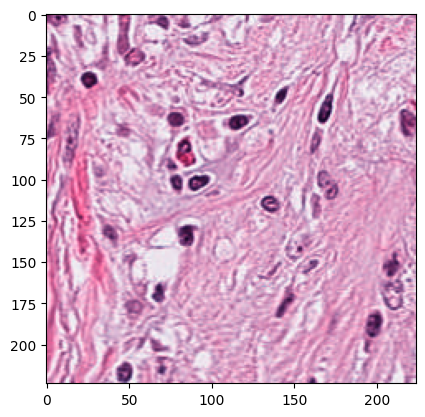

In [13]:
d_train_tiny = Dataset('train_tiny')


rand_i = np.random.randint(len(d_train_tiny))
image_tensor = d_train_tiny[rand_i][0]

# Assuming the tensor is in the correct format
image_numpy = image_tensor.permute(1, 2, 0).numpy().astype('uint8')
print(TISSUE_CLASSES[d_train_tiny[rand_i][1].item()])
# Display the image
plt.imshow(image_numpy)
plt.show()

Commited prev Dataset (because wrote own)

In [ ]:
# d_train_tiny = Dataset('train_tiny')

# img, lbl = d_train_tiny.random_image_with_label()
# print()
# print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
# print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

# pil_img = Image.fromarray(img)
# IPython.display.display(pil_img)

#LB 3

Data loader for NN

In [9]:
def get_dataloader(dataset, name):

  batch_size = 28
  if 'train' in name:
    aug = A.Compose([                                  # использую аугментацию
        A.RandomHorizontalFlip(p=0.5),
        A.RandomVerticalFlip(p=0.5),
        A.RandomRotation(degrees=30),
        A.RandomResizedCrop(224),                      # обрезка изображения
        A.ToTensor(),
        A.Normalize(mean=[187.9071, 135.8079, 179.5519], std=[32.6107, 41.3495, 30.6292])   # нормализация изображения
    ])
    #dataset = Dataset(name)
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,                 # Перемешиваем для новых батчей
        num_workers=2,
        drop_last=True,
    )
    return loader
  else:
    aug = A.Compose([
        A.ToTensor(),
        A.Normalize(mean=[187.9071, 135.8079, 179.5519], std=[32.6107, 41.3495, 30.6292])
    ])
    #dataset = Dataset(name)

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        drop_last=False,
    )
    return loader

Как вывел mean и std для нормализации

In [10]:
d_train_tiny = Dataset('train_tiny')
train_loader = get_dataloader(d_train_tiny, 'train_tiny')

mean = 0.
std = 0.
total_samples = 0

# Вычислите средние и стандартные значения для каждого канала
for images, _ in train_loader:
    images = images
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print("Средние значения по каналам:", mean)
print("Стандартные отклонения по каналам:", std)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1SxcuL7q7zOteDDlf07rIdkgKzavzcUNf
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 258MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Средние значения по каналам: tensor([188.1168, 136.0152, 179.7652])
Стандартные отклонения по каналам: tensor([32.6554, 41.3942, 30.6649])


Пример изображения из LB2 с выполненной аугментацией

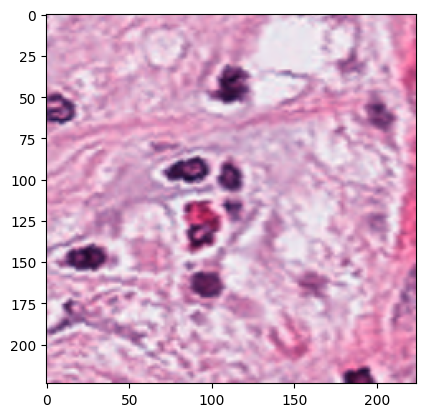

In [14]:
d_train_tiny[rand_i][0]


augmentation = transforms.Compose([
    A.ToTensor(),
    A.RandomHorizontalFlip(),  # Случайное отражение по горизонтали
    A.RandomRotation(degrees=30),  # Случайный поворот на угол до 30 градусов
    A.RandomResizedCrop(224),  # Случайное масштабирование и обрезка
    A.RandomVerticalFlip(),
    A.Normalize(mean=[187.9071, 135.8079, 179.5519], std=[32.6107, 41.3495, 30.6292])
      # Преобразование в тензор
])

augmented_image = augmentation(d_train_tiny[rand_i][0])
normalize_back = A.Normalize(mean=[-187.9071/32.6107, -135.8079/41.3495, -179.5519/30.6292], std=[1/32.6107, 1/41.3495, 1/30.6292])
plt.imshow((normalize_back(augmented_image).permute((1, 2, 0))/255).numpy())
plt.show()

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [15]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

#LB 4

In [16]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [17]:
import wandb     # для построения графиков в реальном времени

In [18]:
wandb.login()       # Если не захотите использовать wandb, то можно нажать ctrl + c

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [68]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet34(pretrained=True)  # использую претрейн
        self.model.fc = nn.Linear(512, 9)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tmp = Metrics()

    def save(self, name):
        with open('/content/drive/MyDrive/HW_MSU/checkpoint.pth', "wb") as fp:
          torch.save(self.model.state_dict(), fp)


    def load(self, name: str):
        name_to_id_dict = {
            'best': '1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P'
        }
        output = 'checkpoint.pth'
        gdown.download(f'https://drive.google.com/uc?id=1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P', output, quiet=False)

        with open('./checkpoint.pth', "rb") as fp:
          state_dict = torch.load(fp)
        self.model.load_state_dict(state_dict)

    def train(self, dt_train):

        wandb.init(
            # set the wandb project where this run will be logged
            project="my-awesome-project_MSU",
            name="adam + res34 - a2",
            # track hyperparameters and run metadata
            reinit=True,
            config={
                "architecture": "CNN",
                "dataset": "From_MSU",
                "epochs": 21,
            }
        )

        tmp = Metrics()

        # первые 3 эпохи будем менять только последний слой
        train_loader = get_dataloader(dt_train, 'train')
        dt_test = Dataset('test')
        val_dataloader = get_dataloader(dt_test, 'test')
        loss_fn = nn.CrossEntropyLoss()               # ф-я потерь
        for layer in list(self.model.children()):
          layer.requires_grad_(False)            # морозим веса, т.к. будем сначала учить только последний слой (для более быстрого обучения)
        list(self.model.children())[-1].weight.requires_grad_(True)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=int(len(train_loader) + 1) * 30)
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        total_loss = 0
        total_acc = 0
        total_n = 0
        self.model.train()
        self.model.to(self.device)

        for epoch in range(30):
          if epoch > 3:
            for layer in list(self.model.children()):
              layer.requires_grad_(True)

          total_loss = 0
          total_loss_val = 0
          self.model.train()
          for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(self.device)
            batch_labels = batch_labels.to(self.device)
            model_labels = self.model(batch_data)
            # model_prediction = model.predict(batch_data)
            new_loss = loss_fn(model_labels, batch_labels)

            optimizer.zero_grad()
            new_loss.backward()
            optimizer.step()
            scheduler.step()

            model_labels = model_labels.cpu().detach().numpy()
            model_labels = np.argmax(model_labels, axis=1)
            one_batch_loss = float(0.3 * tmp.accuracy(model_labels, batch_labels.cpu()) + 0.7 * tmp.accuracy_balanced(model_labels, batch_labels.cpu()))
            #print(one_batch_loss)
            wandb.log({"acc": one_batch_loss})      # логирование
            wandb.log({"lr": optimizer.param_groups[0]["lr"]})

            total_loss += one_batch_loss

          wandb.log({"epoch_acc": total_loss})

          self.save('/content/drive/MyDrive/HW_MSU/checkpoint.pth')

          self.val_test_on_dataset(data_loader=val_dataloader)




    def val_test_on_dataset(self, data_loader, limit=None):

        self.model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        total_loss_val = 0
        all_model_labels = []
        all_batch_labels = []

        with torch.no_grad():

            for batch_data, batch_labels in data_loader:
                batch_data = batch_data.to(self.device)
                batch_labels = batch_labels.to(self.device)
                model_labels = self.model(batch_data)
                model_labels = model_labels.cpu().detach().numpy()
                model_labels = np.argmax(model_labels, axis=1)
                # model_prediction = model.predict(batch_data)
                new_loss = float(0.3 * self.tmp.accuracy(model_labels, batch_labels.cpu()) + 0.7 * self.tmp.accuracy_balanced(model_labels, batch_labels.cpu()))
                wandb.log({"acc_val": new_loss})
                all_model_labels.append(model_labels)
                all_batch_labels.append(batch_labels.cpu())

            all_model_labels = [item for sublist in all_model_labels for item in sublist]
            all_batch_labels = [item for sublist in all_batch_labels for item in sublist]
            total_loss_val = float(0.3 * self.tmp.accuracy(all_model_labels, all_batch_labels) + 0.7 * self.tmp.accuracy_balanced(all_model_labels, all_batch_labels))
            wandb.log({"epoch_acc_val_norm": total_loss_val})


    def test_on_dataset(self, dataset, limit=1):

        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        total_loss_val = 0
        all_model_labels = []
        all_batch_labels = []
        data_loader = get_dataloader(dataset, 'test')

        with torch.no_grad():
          for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(self.device)
            batch_labels = batch_labels.to(self.device)
            model_labels = self.model(batch_data)
            model_labels = model_labels.cpu().detach().numpy()
            model_labels = np.argmax(model_labels, axis=1)
            # model_prediction = model.predict(batch_data)
            new_loss = float(0.3 * self.tmp.accuracy(model_labels, batch_labels.cpu()) + 0.7 * self.tmp.accuracy_balanced(model_labels, batch_labels.cpu()))

            all_model_labels.append(model_labels)


          all_model_labels = [item for sublist in all_model_labels for item in sublist]
          ret_len = int(len(all_model_labels) * limit - 1)
          if limit == 1:
            return all_model_labels
          else:
            return all_model_labels[:ret_len]



    def test_on_image(self, img: np.ndarray):
        # todo: replace this code
        prediction = np.random.randint(9)
        sleep(0.05)
        return prediction

Идёт обучение на 30 эпох. И каждую эпоху сохраняем веса

In [61]:
model = Model()
d_train = Dataset('train')

model.train(d_train)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=13-p56cptVKjfLtLsr9i8cQ_JIcahIcMV
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:07<00:00, 292MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


acc,▁▅▅▆▇▆▇▇▇▇▇█▆▇▇▇▇▇▇▆▇▇▇▇▆▇▇██▇▇▇▇▆▆▇▇▇█▇
acc_val,█▂██▅▃▃██▄▄▂▂▄▂▃▂▂▄▄█▄█▄█▄███▄█▄▄▄▂▂▂▁▄▂
epoch_acc,▁█
epoch_acc_val_norm,▁█
lr,███████████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
acc,1.0
acc_val,0.50333
epoch_acc,578.16326
epoch_acc_val_norm,0.92668
lr,0.0003


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1J0gdEUQliY0YQiF3k_PxEzX61KXi1nJo
To: /content/test.npz
100%|██████████| 525M/525M [00:01<00:00, 335MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

График accuracy на тестовом датасете можно посомтреть по ссылке: https://api.wandb.ai/links/airat-fayzullov-40/binpdr0i

График изменения learning rate: https://wandb.ai/airat-fayzullov-40/my-awesome-project_MSU/reports/lr-23-11-27-02-05-03---Vmlldzo2MDg1NDYw

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [62]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1FosyL3b5rnMBaglli3ZNLDC6uNccaat5
To: /content/train_small.npz
100%|██████████| 841M/841M [00:02<00:00, 300MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1vlgiKd69h_czN8SAWxF8WiBszyqX2y4J
To: /content/test_small.npz
100%|██████████| 211M/211M [00:00<00:00, 294MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [63]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    # model.save('best') это не нужно, т.к. сохраняю каждую эпоху
else:
    model.load('best')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From (uriginal): https://drive.google.com/uc?id=1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P
From (redirected): https://drive.google.com/uc?id=1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P&confirm=t&uuid=f5e9311d-5cdf-4ad8-8483-3d544e910e4e
To: /content/checkpoint.pth
100%|██████████| 85.3M/85.3M [00:00<00:00, 239MB/s]


Пример тестирования модели на части набора данных:

In [64]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


Пример тестирования модели на полном наборе данных:

In [69]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


AAAA
metrics for test:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
# accuracy 0.9889:
# balanced accuracy 0.9889:

In [66]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From (uriginal): https://drive.google.com/uc?id=1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P
From (redirected): https://drive.google.com/uc?id=1pKz6y-8jkmPN1GFWaxEl3DFJ_TN1Zl5P&confirm=t&uuid=ecf4c299-c2c4-4eab-aaa8-7fd6832aaa84
To: /content/checkpoint.pth
100%|██████████| 85.3M/85.3M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?export=download

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


AAAA
metrics for test-tiny:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


Отмонтировать Google Drive.

In [70]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"